In [1]:
import os
import torch
import numpy as np
import pandas as pd

from torch import nn
from torch.utils.data import DataLoader, Dataset
from torchvision import datasets, transforms
from torchvision.transforms import ToTensor, Lambda
import matplotlib.pyplot as plt


In [2]:
available = torch.cuda.is_available()
curr_device = torch.cuda.current_device()
device = torch.device("cuda:0" if available else "cpu")
device_count = torch.cuda.device_count() 
device_name =  torch.cuda.get_device_name(0)

print(f'Cuda available: {available}')
print(f'Current device: {curr_device}')
print(f'Device: {device}')
print(f'Device count: {device_count}')
print(f'Device name: {device_name}')

#device = torch.device("cpu")

Cuda available: True
Current device: 0
Device: cuda:0
Device count: 1
Device name: GeForce GTX 1070


In [3]:
# (Adapted) Code from PyTorch's Resnet impl: https://github.com/pytorch/vision/blob/main/torchvision/models/resnet.py

def conv3x3(in_planes: int, out_planes: int, stride: int = 1, groups: int = 1, dilation: int = 1) -> nn.Conv2d:
    """3x3 convolution with padding"""
    return nn.Conv2d(
        in_planes,
        out_planes,
        kernel_size=3,
        stride=stride,
        padding=dilation,
        groups=groups,
        bias=False,
        dilation=dilation,
    )


def conv1x1(in_planes: int, out_planes: int, stride: int = 1) -> nn.Conv2d:
    """1x1 convolution"""
    return nn.Conv2d(in_planes, out_planes, kernel_size=1, stride=stride, bias=False)


class Bottleneck(nn.Module):
    # Bottleneck in torchvision places the stride for downsampling at 3x3 convolution(self.conv2)
    # while original implementation places the stride at the first 1x1 convolution(self.conv1)
    # according to "Deep residual learning for image recognition"https://arxiv.org/abs/1512.03385.
    # This variant is also known as ResNet V1.5 and improves accuracy according to
    # https://ngc.nvidia.com/catalog/model-scripts/nvidia:resnet_50_v1_5_for_pytorch.

    expansion: int = 1

    def __init__(
        self,
        inplanes: int,
        planes: int,
        stride: int = 1,
        downsample = None,
        groups: int = 1,
        base_width: int = 64,
        dilation: int = 1,
        norm_layer = None,
        use_final_relu = True,
    ) -> None:
        super().__init__()
        if norm_layer is None:
            norm_layer = nn.BatchNorm2d
        width = int(planes * (base_width / 64.0)) * groups
        # Both self.conv2 and self.downsample layers downsample the input when stride != 1
        self.conv1 = conv1x1(inplanes, width)
        self.bn1 = norm_layer(width)
        self.conv2 = conv3x3(width, width, stride, groups, dilation)
        self.bn2 = norm_layer(width)
        
        # BK: Force last layers back to inplanes
        self.conv3 = conv1x1(width, inplanes)
        self.bn3 = norm_layer(inplanes)
        self.relu = nn.ReLU(inplace=True)
        self.downsample = downsample
        self.stride = stride
        
        self.use_final_relu = use_final_relu

    def forward(self, x):
        identity = x

        out = self.conv1(x)
        #out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        #out = self.bn2(out)
        out = self.relu(out)

        out = self.conv3(out)
        #out = self.bn3(out)

        if self.downsample is not None:
            identity = self.downsample(x)

        out += identity
        if self.use_final_relu:
            out = self.relu(out)

        return out

In [4]:
class Reshape(nn.Module):
    def __init__(self, shape):
        super(Reshape, self).__init__()
        self.shape = tuple([-1] + list(shape))
        
    def forward(self, x):
        return torch.reshape(x, self.shape)

def dense_backbone(shape, network_width):
    input_width = shape[0] * shape[1] * shape[2]
    return nn.Sequential(
        nn.Flatten(),
        nn.Linear(input_width, network_width),
        nn.ReLU(),
        nn.Linear(network_width, input_width),
        Reshape(shape)
    )

def bottleneck_backbone(in_planes, planes):
    return nn.Sequential(
        Bottleneck(in_planes, planes, use_final_relu=False),
        Bottleneck(in_planes, planes, use_final_relu=False),
        Bottleneck(in_planes, planes, use_final_relu=False),
        Bottleneck(in_planes, planes, use_final_relu=False),
    )

check_mask = {}
check_mask_device = {}
def checkerboard_mask(shape, to_device=True):
    global check_mask, check_mask_device
    if shape not in check_mask:
        check_mask[shape] = 1 - np.indices(shape).sum(axis=0) % 2
        check_mask[shape] = torch.Tensor(check_mask[shape])
        
    if to_device and shape not in check_mask_device:
        check_mask_device[shape] = check_mask[shape].to(device)
        
    return check_mask_device[shape] if to_device else check_mask[shape]

chan_mask = {}
chan_mask_device = {}
def channel_mask(shape, to_device=True):
    assert len(shape) == 3, shape
    assert shape[0] % 2 == 0, shape
    global chan_mask, chan_mask_device
    if shape not in chan_mask:
        chan_mask[shape] = torch.cat([torch.zeros((shape[0] // 2, shape[1], shape[2])),
                                      torch.ones((shape[0] // 2, shape[1], shape[2])),],
                                      dim=0)
        assert chan_mask[shape].shape == shape, (chan_mask[shape].shape, shape)
        
    if to_device and shape not in chan_mask_device:
        chan_mask_device[shape] = chan_mask[shape].to(device)
        
    return chan_mask_device[shape] if to_device else chan_mask[shape]

In [585]:
class NormalizingFlowMNist(nn.Module):
    EPSILON = 1e-7
    
    def __init__(self, num_coupling=6, num_final_coupling=4, planes=64):
        super(NormalizingFlowMNist, self).__init__()
        self.num_coupling = num_coupling
        self.num_final_coupling = num_final_coupling
        self.shape = (1, 28, 28)
        
        self.planes = planes
        self.s = nn.ModuleList()
        self.t = nn.ModuleList()
        
        # Learnable scalar scaling parameters for outputs of S and T
        self.s_scale = nn.ParameterList()
        self.t_scale = nn.ParameterList()
        self.t_bias = nn.ParameterList()
        self.shapes = []
      
        shape = self.shape
        for i in range(num_coupling):
            self.s.append(bottleneck_backbone(shape[0], planes))
            self.t.append(bottleneck_backbone(shape[0], planes))
            
            self.s_scale.append(torch.nn.Parameter(torch.zeros(shape), requires_grad=True))
            self.t_scale.append(torch.nn.Parameter(torch.zeros(shape), requires_grad=True))
            self.t_bias.append(torch.nn.Parameter(torch.zeros(shape), requires_grad=True))
                          
            torch.nn.init.normal_(self.s_scale[i], std=0.1)
            torch.nn.init.normal_(self.t_scale[i], std=0.1)
            
            self.shapes.append(shape)
           
            if i % 6 == 2:
                
                shape = (4 * shape[0], shape[1] // 2, shape[2] // 2)
                
            if i % 6 == 5:
                # Factoring out half the channels
                shape = (shape[0] // 2, shape[1], shape[2])
       
        # Coupling layers checkerboard
        for i in range(num_final_coupling):
            self.s.append(bottleneck_backbone(shape[0], planes))
            self.t.append(bottleneck_backbone(shape[0], planes))
            
            self.s_scale.append(torch.nn.Parameter(torch.zeros(shape), requires_grad=True))
            self.t_scale.append(torch.nn.Parameter(torch.zeros(shape), requires_grad=True))
            self.t_bias.append(torch.nn.Parameter(torch.zeros(shape), requires_grad=True))
                          
            self.shapes.append(shape)
           
        self.validation = False
    
    def validate(self):
        self.validation = True
        self.eval()
        
    def train(self, mode=True):
        nn.Module.train(self, mode)
        if mode:
            self.validation = False

    def forward(self, x):
        if model.training or self.validation:
            s_vals = []
            y_vals = []
            
            for i in range(self.num_coupling):
                shape = self.shapes[i]
                mask = checkerboard_mask(shape) if i % 6 < 3 else channel_mask(shape)
                mask = mask if i % 2 == 0 else (1 - mask)
               
                t = (self.t_scale[i]) * self.t[i](mask * x) + (self.t_bias[i])
                s = (self.s_scale[i]) * torch.tanh(self.s[i](mask * x))
                y = mask * x + (1 - mask) * (x * torch.exp(s) + t)
                s_vals.append(torch.flatten((1 - mask) * s))
                
                if i % 6 == 2:
                    y = torch.nn.functional.pixel_unshuffle(y, 2)
                    
                if i % 6 == 5:
                    factor_channels = y.shape[1] // 2
                    y_vals.append(torch.flatten(y[:, factor_channels:, :, :], 1))
                    y = y[:, :factor_channels, :, :]
                    
                x = y
                
            # Final checkboard coupling
            for i in range(self.num_coupling, self.num_final_coupling):
                shape = self.shapes[i]
                mask = checkerboard_mask(shape)
                mask = mask if i % 2 == 0 else (1 - mask)
               
                t = (self.t_scale[i]) * self.t[i](mask * x) + (self.t_bias[i])
                s = (self.s_scale[i]) * torch.tanh(self.s[i](mask * x))
                y = mask * x + (1 - mask) * (x * torch.exp(s) + t)
                s_vals.append(torch.flatten((1 - mask) * s))
                
                x = y

            y_vals.append(torch.flatten(y, 1))
            
            # Return outputs and vars needed for determinant
            return (torch.flatten(torch.cat(y_vals, 1), 1),
                    torch.cat(s_vals), 
                    torch.cat([torch.flatten(s) for s in self.s_scale]))
        else:
            y = x
            y_remaining = y
           
            layer_vars = np.prod(self.shapes[-1])
            y = torch.reshape(y_remaining[:, -layer_vars:], (-1,) + self.shapes[-1])
            y_remaining = y_remaining[:, :-layer_vars]
            
            
            # Reversed final checkboard coupling
            for i in reversed(range(self.num_coupling, self.num_final_coupling)):
                shape = self.shapes[i]
                mask = checkerboard_mask(shape)
                mask = mask if i % 2 == 0 else (1 - mask)
              
                t = (self.t_scale[i]) * self.t[i](mask * y) + (self.t_bias[i])
                s = (self.s_scale[i]) * torch.tanh(self.s[i](mask * y))
                x = mask * y + (1 - mask) * ((y - t) * torch.exp(-s))
               
                y = x           
          
            layer_vars = np.prod(shape)
            y = torch.cat((y, torch.reshape(y_remaining[:, -layer_vars:], (-1,) + shape)), 1)
            y_remaining = y_remaining[:, :-layer_vars]
            
            # Multi-scale coupling layers
            for i in reversed(range(self.num_coupling)):
                shape = self.shapes[i]
                mask = checkerboard_mask(shape) if i % 6 < 3 else channel_mask(shape)
                mask = mask if i % 2 == 0 else (1 - mask)
              
                t = (self.t_scale[i]) * self.t[i](mask * y) + (self.t_bias[i])
                s = (self.s_scale[i]) * torch.tanh(self.s[i](mask * y))
                x = mask * y + (1 - mask) * ((y - t) * torch.exp(-s))
               
                if i % 6 == 3:
                    x = torch.nn.functional.pixel_shuffle(x, 2)
                    
                y = x
                
                if i > 0 and i % 6 == 0:
                    layer_vars = np.prod(shape)
                    y = torch.cat((y, torch.reshape(y_remaining[:, -layer_vars:], (-1,) + shape)), 1)
                    y_remaining = y_remaining[:, :-layer_vars]
            
            assert np.prod(y_remaining.shape) == 0
            
            return x

In [586]:
PI = torch.tensor(np.pi).to(device)
def loss_fn(y, s, scale, batch_size):
    # -log(zero-mean gaussian) + log determinant
    # -log p_x = log(pz(f(x))) + log(det(\partial f/\partial x))
    # -log p_x = 0.5 * y**2 + s1 + s2 + ...
    logpx = -torch.sum(0.5 * torch.log(2 * PI) + 0.5 * y**2)
    det = torch.sum(s)
    reg = 5e-5 * torch.sum(scale ** 2)
    loss = -(logpx + det) + reg
    #print(f"{-logpx / batch_size:.2f} / {loss / batch_size:.2f}")
    return torch.div(loss, batch_size)

# MNist Training

In [587]:
def pre_process(x):
    # Convert back to integer values
    x = x * 255.
    
    # Add random uniform [0, 1] noise to get a proper likelihood estimate
    # https://bjlkeng.github.io/posts/a-note-on-using-log-likelihood-for-generative-models/
    
    # TODO FIX ME
    x = x + torch.rand(x.shape)
    
    # Apply transform to deal with boundary effects (see realNVP paper)
    #x = torch.logit(0.05 + 0.90 * x / 256)
    #return x
    return x / 255

def post_process(x):
    # Convert back to integer values
    #return torch.clip(torch.floor(256 / 0.90 * (torch.sigmoid(x) - 0.05)), min=0, max=255) / 255
    return torch.clip(x, min=0, max=1)

In [588]:
train_dataset = datasets.MNIST('data', train=True, download=True,
                               transform=transforms.Compose([
                                   transforms.ToTensor(),
                               ]))
test_dataset = datasets.MNIST('data', train=False, download=True,
                              transform=transforms.Compose([
                                  transforms.ToTensor(),
                              ]))

In [589]:
def train_loop(dataloader, model, loss_fn, optimizer, report_iters=10, num_pixels=28*28):
    size = len(dataloader)
    prev = []
    for batch, (X, _) in enumerate(dataloader):
        # Transfer to GPU
        X = pre_process(X)
        X = X.to(device)
        
        # Compute prediction and loss
        y, s, scale = model(X)
        loss = loss_fn(y, s, scale, batch_size)
        
        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        
        prev = [(name, x, x.grad) for name, x in model.named_parameters(recurse=True)]
        optimizer.step()

        if batch % report_iters == 0:
            loss, current = loss.item(), batch
            print(f"loss: {loss:.2f}; {loss / num_pixels / np.log(2):>.2f}  [{current:>5d}/{size:>5d}]")
            
        # FIX ME
        if batch >= 0:
            break

def test_loop(dataloader, model, loss_fn, num_pixels=28*28):
    size = len(dataloader)
    num_batches = len(dataloader)
    test_loss = 0

    with torch.no_grad():
        model.validate()
        for X, _ in dataloader:
            X = pre_process(X)
            X = X.to(device)
            y, s, scale = model(X)
            test_loss += loss_fn(y, s, scale, batch_size)
        model.train()

    test_loss /= num_batches
    print(f"Test Error: \n Avg loss: {test_loss:.2f}; {test_loss / num_pixels / np.log(2):.2f} \n")

In [590]:
learning_rate = 0.01
batch_size = 10
epochs = 300

model = NormalizingFlowMNist(12, 96).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=50, gamma=0.4)


train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False) #shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size,  shuffle=False) #shuffle=True)

for t in range(epochs):
    #TODO FIX ME
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False) #shuffle=True)
    print(f"Epoch {t+1}\n-------------------------------")
    train_loop(train_loader, model, loss_fn, optimizer)
    # TODO FIX ME
    #test_loop(test_loader, model, loss_fn)
    
    scheduler.step()

print("Done!")

Epoch 1
-------------------------------
loss: 759.80; 1.40  [    0/ 6000]
Epoch 2
-------------------------------
loss: 1394.58; 2.57  [    0/ 6000]
Epoch 3
-------------------------------
loss: 768.38; 1.41  [    0/ 6000]
Epoch 4
-------------------------------
loss: 813.44; 1.50  [    0/ 6000]
Epoch 5
-------------------------------
loss: 683.35; 1.26  [    0/ 6000]
Epoch 6
-------------------------------
loss: 630.42; 1.16  [    0/ 6000]
Epoch 7
-------------------------------
loss: 561.76; 1.03  [    0/ 6000]
Epoch 8
-------------------------------
loss: 480.96; 0.89  [    0/ 6000]
Epoch 9
-------------------------------
loss: 433.91; 0.80  [    0/ 6000]
Epoch 10
-------------------------------
loss: 540.40; 0.99  [    0/ 6000]
Epoch 11
-------------------------------
loss: 386.92; 0.71  [    0/ 6000]
Epoch 12
-------------------------------
loss: 334.20; 0.61  [    0/ 6000]
Epoch 13
-------------------------------
loss: 244.83; 0.45  [    0/ 6000]
Epoch 14
------------------------

loss: -1645.35; -3.03  [    0/ 6000]
Epoch 108
-------------------------------
loss: -1654.55; -3.04  [    0/ 6000]
Epoch 109
-------------------------------
loss: -1656.28; -3.05  [    0/ 6000]
Epoch 110
-------------------------------
loss: -1658.05; -3.05  [    0/ 6000]
Epoch 111
-------------------------------
loss: -1661.92; -3.06  [    0/ 6000]
Epoch 112
-------------------------------
loss: -1670.66; -3.07  [    0/ 6000]
Epoch 113
-------------------------------
loss: -1667.98; -3.07  [    0/ 6000]
Epoch 114
-------------------------------
loss: -1675.65; -3.08  [    0/ 6000]
Epoch 115
-------------------------------
loss: -1689.39; -3.11  [    0/ 6000]
Epoch 116
-------------------------------
loss: -1700.69; -3.13  [    0/ 6000]
Epoch 117
-------------------------------
loss: -1700.09; -3.13  [    0/ 6000]
Epoch 118
-------------------------------
loss: -1706.18; -3.14  [    0/ 6000]
Epoch 119
-------------------------------
loss: -1719.76; -3.16  [    0/ 6000]
Epoch 120
-----

loss: -2008.48; -3.70  [    0/ 6000]
Epoch 212
-------------------------------
loss: -2010.08; -3.70  [    0/ 6000]
Epoch 213
-------------------------------
loss: -2013.14; -3.70  [    0/ 6000]
Epoch 214
-------------------------------
loss: -2009.72; -3.70  [    0/ 6000]
Epoch 215
-------------------------------
loss: -2014.05; -3.71  [    0/ 6000]
Epoch 216
-------------------------------
loss: -2008.96; -3.70  [    0/ 6000]
Epoch 217
-------------------------------
loss: -2015.77; -3.71  [    0/ 6000]
Epoch 218
-------------------------------
loss: -2019.37; -3.72  [    0/ 6000]
Epoch 219
-------------------------------
loss: -2016.01; -3.71  [    0/ 6000]
Epoch 220
-------------------------------
loss: -2019.10; -3.72  [    0/ 6000]
Epoch 221
-------------------------------
loss: -2020.80; -3.72  [    0/ 6000]
Epoch 222
-------------------------------
loss: -2018.52; -3.71  [    0/ 6000]
Epoch 223
-------------------------------
loss: -2017.38; -3.71  [    0/ 6000]
Epoch 224
-----

# Debug - Check that foward/reverse are (about) equal

In [591]:
# DEBUG - Check

model.train()
with torch.no_grad():
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False) #shuffle=True)
    for x, _ in train_loader:
        x_pre = pre_process(x).to(device)
        y, s, scale = model(x_pre)
        print(y.shape)
        break

model.eval()
with torch.no_grad():
    xp = model(y)
    x_post = post_process(xp)

diff = x.to(device) - x_post
torch.any(torch.abs(diff) > 1 / 255)

torch.Size([10, 784])


tensor(False, device='cuda:0')

In [592]:
print(diff.shape)

for i in range(batch_size):
    if torch.any(torch.abs(diff[i]) > 1 / 255):
        #print(diff[i])
        for j in range(28):
            for k in range(28):
                if torch.any(torch.abs(diff[i, 0, j, k]) > 1 / 255):
                    print(i, 1, j, k, diff[i, 0, j, k].cpu().numpy())
                    break
        break

torch.Size([10, 1, 28, 28])


count    7840.000000
mean       -0.014234
std         0.427264
min        -2.675436
25%        -0.109771
50%        -0.002367
75%         0.089574
max         3.013013
dtype: float64


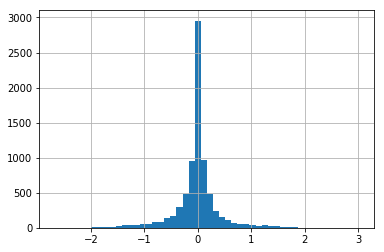

In [593]:
s = pd.Series(torch.flatten(y).cpu().numpy())
print(s.describe())
s.hist(bins=50)

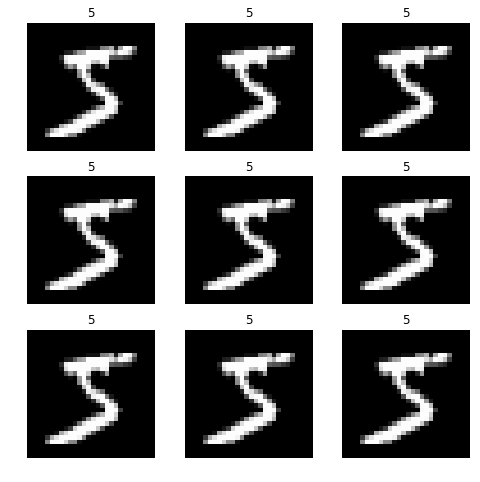

In [594]:
figure = plt.figure(figsize=(8, 8))
cols, rows = 3, 3
for i in range(1, cols * rows + 1):
    # TODO FIX ME
    #sample_idx = torch.randint(len(train_dataset), size=(1,)).item()
    sample_idx = 0
    img, label = train_dataset[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(str(label))
    plt.axis("off")
    plt.imshow(img.squeeze(), cmap="gray")
plt.show()

In [595]:
model.eval()
with torch.no_grad():
    X = torch.Tensor(torch.randn((1, 28 * 28 * 1))).to(device)
    Y = model(X)
    samples = post_process(Y).cpu().numpy()

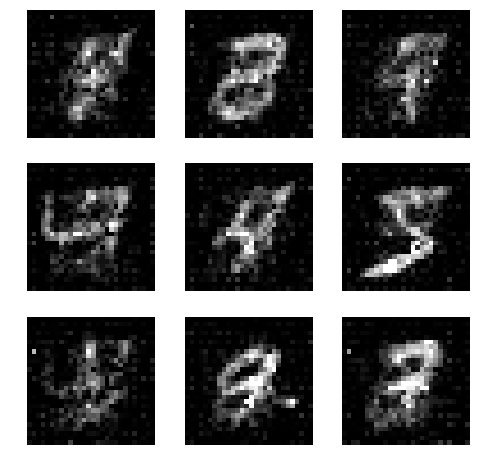

In [605]:
model.eval()

cols, rows = 3, 3
with torch.no_grad():
    X = torch.Tensor(torch.normal(torch.zeros(cols * rows, 28 * 28 * 1),
                                  torch.ones(cols * rows, 28 * 28 * 1))).to(device)
    #X = torch.Tensor(torch.zeros(cols * rows, 28 * 28 * 1)).to(device)
    Y = model(X)
    samples = post_process(Y).cpu().numpy()

figure = plt.figure(figsize=(8, 8))
for i in range(1, cols * rows + 1):
    img = samples[i - 1]
    figure.add_subplot(rows, cols, i)
    plt.axis("off")
    plt.imshow(img.squeeze(), cmap="gray")
plt.show()

# 2022-02-13

* Adding several checkerboard coupling layers at the end (with just one super-scale iteration) seemed to make fitting on a single image much better (sampling from a standard normal -- no more sampling from zeros):

  * I suspect these coupling layers have very limited transformation power, that's why you need so many of them to even translate things.
  * Detail: I'm still using pixel (no pre-processing) but am adding the U(0,1) pixel noise
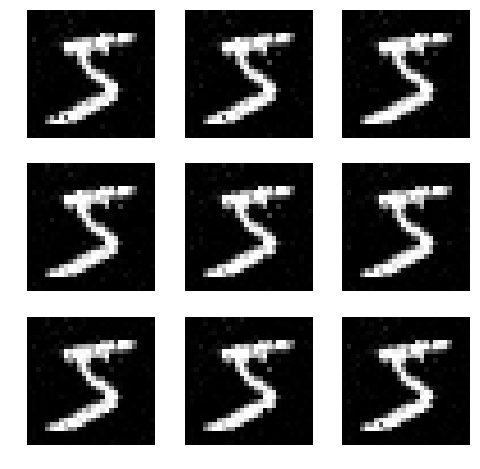


* When I try to fit two images though, I get something that looks like a superposition (between "5" and "0"):
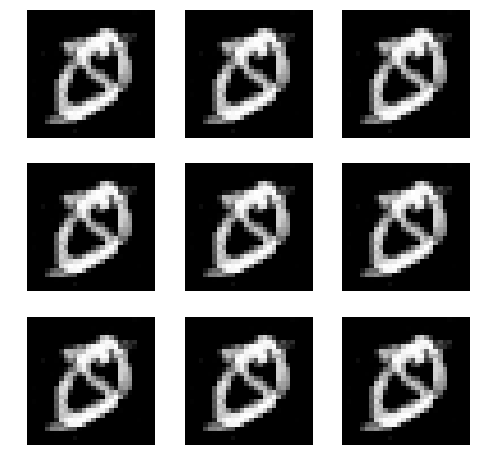

* Adding two multi-scale iterations (3 checker, 1 squeeze, 3 channel, 3 checker, 1 squeeze, 3 channel) + 4 checker) with two images
    * Gets me closer to something that looks right
    * It's still confusing things but can sometimes, *sort of* distiguish between "5" and "0" making some parts of the 0 darker to make the 5 standout (and vice versa)
* I probably need the factoring out of variables that theoretically will have local/global sort of effect?    

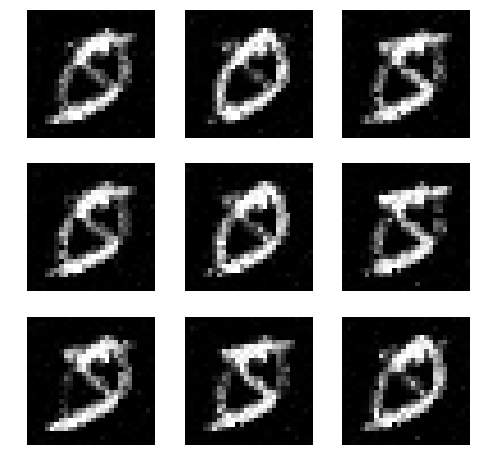

* Added the factoring code, surprisingly it wasn't that bad.  Pytorch is pretty easy to work with!
* I can *sort of* do 2 images now?  In some cases, you have a clear distinction between "5" and "0".  In others, it's mixed.
    * I think I just need longer training to perfect them... let's see.
    * More noise of course, but maybe because I need more training?

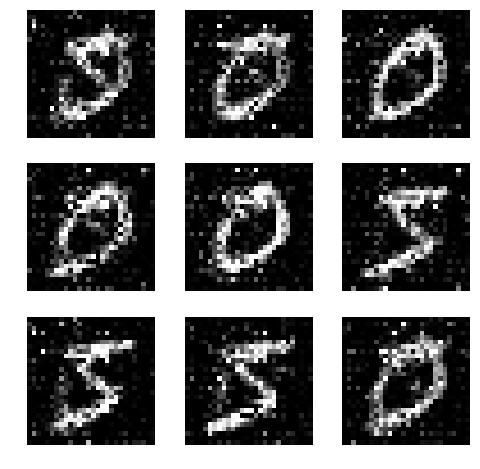

* More training and training with 10 points, get something kind of blurry, but sort of recognizable
* Need to do more investigation why the pictures aren't that sharp -- not clear to me at the moment
* I tried increasing planes 64 -> 96, still get kind of the same loss (about -3.8/pixel)
* The distribution mean is close to 0 (0.04) but std is around 0.4, not close to 1 (which was what it was when I trained a single example above)
* Feels like I need more capacity

TODO:

* Try to increase number of bottleneck layers (4 -> 8)?

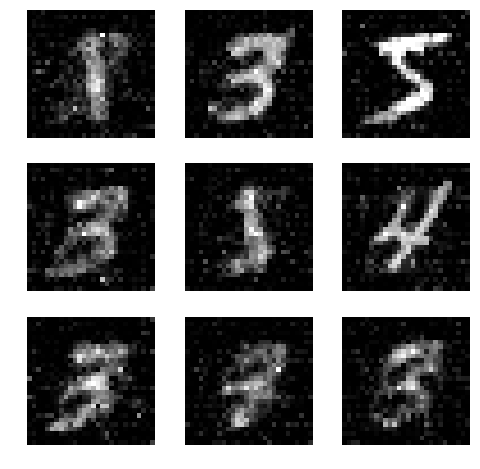

# 2022-02-12

* Implemented the multi-scale architecture (with just one iteration)
    * 3 checkerboard, squeeze, 3 channel
* I can *sort of* overfit on a single image, but if I try to increase number of images, I still don't get anything that resembles a number.
    * My conclusion is that checkboard alone cannot model an overal image, esp. if you are just going back and forth on the same variables.
    * You want some mixing of variables (not just swapping back and forth), especially because these are affine transformations.
    * Additionally, since the original # of channels = 1 (greyscale image), the conv operation is probably not doing much, as opposed to after squeeze, you have many more channels to work with
* However... it does suggest something more plausible:
    * Some center of mass
    * Very dark and/or light pixels
* NEXT:
    * Try to implement more than one iteration of multi-scale architecture
    * AND partition out some vars after each iteration (like the paper)
    * Supposedly the lower Gaussians model the coarse detail, while the later ones will model finer detail
    * If that is true, then it explains why I just get a big blob in the center


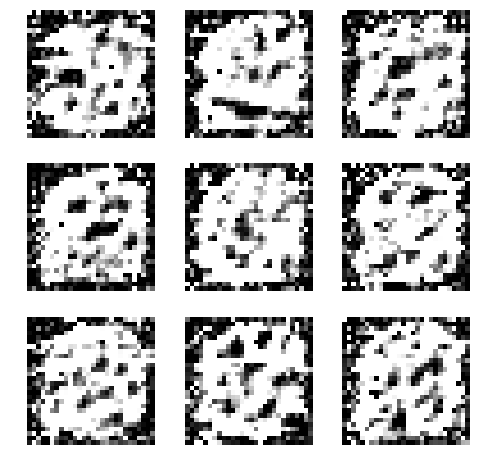

# 2022-02-10

* Tried adding scale/bias parameters to make affine transform in the "t" var -- didn't really do anything
* Tried to overfit on a **single** image
    * By sampling from zeros(.), I can generate something *close* to the original image (not a perfect match) has a bit of noise still
    * Strange I can't get a better fit... why is there still so much noise?

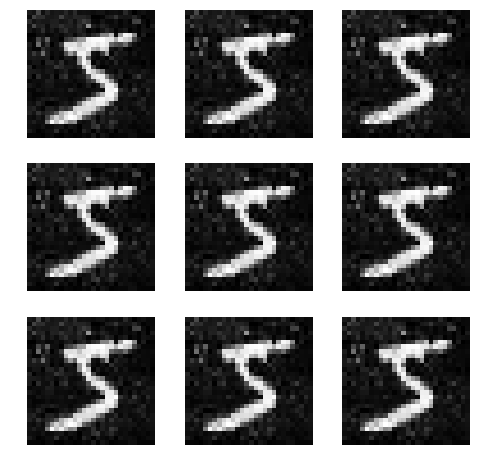

* Tried removing U(0,1) pixel noise -- didn't seem to work
* Tried removing determinant from loss function -- didn't seem work
* Tried removing this post-processing -- get a much clearer image ???
* Tried training with 10 images -- get garbage when sampling from normal (but lots of 0/255)

INVESTIGATE: 

* What is going on with post-processing?
* Why doesn't training with 10 images work?
    

# 2022-02-05

* Looks like the inverse operation is working as expected:
  * Pass in a vector in forward pass pixels -> pre_process -> gaussian -> post_process -> pixels and get the same number (with some small 10e-8 errors, also had some 10-3 errors but much more seldom)
* Added L2 regularizer on s_scale param, not much changed
* I keep getting a shifted distribution (negative mean) and less than 1 std when I take a batch of training and pass it through a forward pass to get z
  * Tried removing the det terms and it still looks skewed
* INVESTIGATE: This seems like it's relevant because if I'm sampling from a 0-mean Gaussian but real examples always end up shifted left, then of course I'm going to generate bad images
* ANOTHER IDEA: overfit on a much smaller training set (10, 100 images)

# 2022-02-02

* Implemented post-processing to convert back to pixel space but still seems like I'm getting garbage, need to debug further.
* Ideas to double check:
    * loss function
    * inverse operation (should check back and forwards give the same answer)
    * Check that forward pass actually gives something Gaussian like...

# 2022-02-01

* Finally got around to actually generating images... and they are just noise!
* Might be a bug in the network, might be that I need to increase capacity of network.  Now the fun starts!
    * I might also have to add the "multi-scale architecture"
    * Another issue might be the batch-norm layers, which probably behave very differently in testing -- I actually did comment it out.
    
    
I NEED TO CONVERT BACK TO PIXEL SPACE!!!!

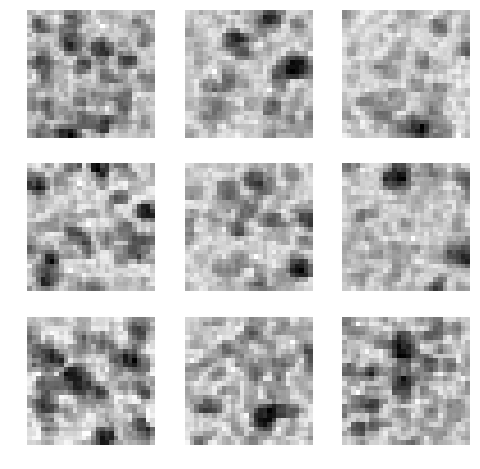

# 2022-01-31

* The negative values are coming from determinant because log |df/dx| = log(|exp(s)|) = s
* So the loss is essentially trying to make `s` very large (more negative).
* Theoretically, it's possible by allowing the unmasked variables to almost exactly predict the masked variables, so you could multiply by a large number s(unmasked) vars, and adjust by t(unmasked) = -s(unmasked) * unmasked, to get the maximum s*masked_x - t = s*unmasked_x - s*unmasked_x = 0, which is the maximum density point for the Gaussian
* Need to look into how the determinant (i.e. s) is be generated.  From prelim debugging above, it looks like it's generating a lot of zeros (even in unmasked positions), so I have to sort out why that's the case.

Wait... found a bug.  I was putting the determinant as `mask * s` instead of the correct `(1 - mask) * s`.


# 2022-01-29

* Getting lots of NaNs -- debugged a bunch of things:
    * Removed Resnet
    * Removed exp()
    * Made forward pass a simple feedforward
* But it looks like issue is the data???    
    * The stupid paper said the transform should be `logit(alpha + (1-alpha)*x/256)`...
    * Data is originally in [0,1] (pytorch dataset)
    * Convert back to pixels multiply by 255
    * Add jitter to get upper bound on bits per pixel (see my post)
    * Range is now [0, 256]
    * Suggested alpha=0.05 (I had a bug and used 0.5)
    * But that gets you really close to 256 (jitter is always less than 1.0 though) e.g.i logit(0.05 + 0.95 * ~255.99/256) ~= \inf!
    * Instead, I used this `logit(alpha + (1-alpha - 0.05)*x/256)`, which is symmetrical...
    
NEXT STEPS:
* So things look good now, except that I get a negative loss, which shouldn't happen (after applying jitter)???
    * It's because I need a new uniform noise sample per EPOCH???
    * Or is it because I'm using continuous variables on the output?  So maybe I just need to measure this "loss" when I reverse the network?  
        * It's probably this... if it's a continuous output, the log density surely doesn't need to be positive (vs. if I were directly outputting pixel values).
        
        
I THINK I FIGURED IT OUT:  IT's becuase I didn't have the 1/sqrt(2pi) in the log-likelihood!

In [ ]:
pixel_unshuffle = nn.PixelUnshuffle(2)
x = np.arange(64).reshape((1, 1, 8, 8))
x = torch.tensor(x)
print(x.shape)
print(x)
output = pixel_unshuffle(x)
print(output.shape)
output

In [ ]:
output[0, :, 0 , 0]